In [19]:
from dataclasses import dataclass
import enum
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
from IPython.display import Markdown
import itertools
from matplotlib import gridspec, pyplot as plt
from sklearn.metrics import auc, roc_auc_score, roc_curve
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from db import Database, get_df

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats


set_matplotlib_formats('svg')


pd.set_option('display.max_rows', None)


def neg_rp(mu, sigma):
    try:
        _r = pow(mu,2)/(pow(sigma,2) - mu)
        _p = mu/pow(sigma,2)
        # print(f'{_r > 0 and (_p >= 0 and _p <=1)}\tmu={mu}\tsimga={sigma}\t_r={_r}\t_p={_p}')
        return _r, _p
    except:
        return neg_rp(mu - 1, sigma)
    

@dataclass()
class SigmaMu:
    mu: float
    sigma: float
    pass


class SimulateMode(enum.Enum):
    NORMAL = 0,
    NEGATIVE_BINOMIAL = 1
    pass


@dataclass()
class SimulateParams:
    fp: SigmaMu
    tp: SigmaMu
    mode: SimulateMode
    pass


def simulate(params: SimulateParams, n=30*24, p=10*24):
    if params.mode == SimulateMode.NORMAL:
        fps = np.random.normal(loc=params.fp.mu, scale=params.fp.sigma, size=n)
        tps = np.random.normal(loc=params.tp.mu, scale=params.tp.sigma, size=p)
    elif params.mode == SimulateMode.NEGATIVE_BINOMIAL:
        _r,_p = neg_rp(params.fp.mu, params.fp.sigma)
        fps = np.random.negative_binomial(_r, _p, size=n)
        _r,_p = neg_rp(params.tp.mu, params.tp.sigma)
        tps = np.random.negative_binomial(_r, _p, size=p)
        pass

    tps = np.concatenate([np.zeros(n-p), tps])
    labels = np.concatenate([np.zeros(n-p), np.ones(p)])

    fpr, tpr, thresholds = roc_curve(labels, (fps + tps))
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax((tpr - fpr)) # np.argmax((fpr < 0.05) * (tpr - fpr))

    roc_auc_001 = roc_auc_score(labels, (fps + tps), max_fpr=0.01)
    optimal_idx_fpr001 = np.argmax((fpr < 0.01) * (tpr - fpr))

    th_001_range = (fpr < 0.01).sum() / len(fpr)

    return th_001_range, thresholds[optimal_idx], fpr[optimal_idx], tpr[optimal_idx], thresholds[optimal_idx_fpr001], fpr[optimal_idx_fpr001], tpr[optimal_idx_fpr001], roc_auc, roc_auc_001

def simulate_montecarlo(N, sp: SimulateParams, n=30*24, p=10*24):
    res = []
    for i in range(N):
        _ = simulate(sp, n, p)
        res.append(_)
        pass
    return pd.DataFrame(res, columns="th_001_range,th,fpr,tpr,th_001,fpr_001,tpr_001,roc_auc,roc_auc_001".split(','))

def simulate_montecarlo_mean(N, sp: SimulateParams, n=30*24, p=10*24):
    df = simulate_montecarlo(N, sp, n, p)
    th,fpr,tpr,roc_auc = df.mean().to_list()
    return th,fpr,tpr,roc_auc

def simulate_loop(mu_fp, mu_tp_ratio, sm: SimulateMode):
    res = []
    sigma_props_fp=map(lambda x: x*1.0/10.0+0.2, range(1, 11, 1))
    sigma_props_tp=map(lambda x: x*1.0/10.0+0.2, range(1, 11, 1))
    for sigma_fp_prop, sigma_tp_prop in list(itertools.product(sigma_props_fp, sigma_props_tp)):
        sp = SimulateParams(SigmaMu(mu_fp, mu_fp * sigma_fp_prop), SigmaMu(mu_fp * mu_tp_ratio, mu_fp * mu_tp_ratio * sigma_tp_prop), sm)
        th, fpr, tpr, roc_auc = simulate_montecarlo(10, sp)
        res.append([sigma_fp_prop, sigma_tp_prop, th, fpr, tpr, roc_auc])
        pass
    return pd.DataFrame(res, columns='sigma_fp/mu_fp,sigma_tp/mu_tp,th,fpr,tpr,roc_auc'.split(','))


# Simulazione con distribuzione normale

Le strisce verticali indicano come la $\sigma_{fp}$ influisca pesantemente
nella roc_auc. Contrariamente, $\sigma_{tp}$ influenza quasi minimamente
roc_auc.

Come è ovvio che sia, il rapporto $\mu_{tp}/\mu_{fp}$ implica che la roc_auc
acquisisca valori migliori tanto più quanto quest'ultimo ha valori crescenti.

Sebbene sia ovvio che $\mu_{fp}$ e $\mu_{tp}$ possano avere un'influenza
considerevole, non lo è per quanto riguarda le varianze, soprattutto per quanto
riguarda $\sigma_{fp}$.

## ROC_AUC

Tale parametro è tanto migliore quanto più è prossimo ad uno. Nel caso si
avvicini a 0.5, indica un classificatore _inutile_, ovvero il cui esito è
equivalente al lancio di una moneta.

La curva ROC è utilizzata per capire le perfomance di un classificatore binario:
essa mostra il rapporto ottenuto tra FPR e TPR per tutti i possibili valori di
soglia, calcolati dalla funzione `roc_curve`.

In [ ]:

fig = plt.figure(figsize=(12,6))
for k, mu_fp in enumerate([50, 100]):
    gs = fig.add_gridspec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], hspace=0.05)  # 4 quadranti per le heatmap, 1 per la colormap

    for i, mu_tp_ratio in enumerate([0.1, 0.4, 0.8, 1.0, 1.2]):
        if i == 0:
            ax = fig.add_subplot(gs[k, i])
        else:
            ax = fig.add_subplot(gs[k, i])#, sharey=ax0)

        df = simulate_loop(mu_fp, mu_tp_ratio, SimulateMode.NORMAL).round(4).sort_index()
        df = df.pivot(columns='sigma_fp/mu_fp', index='sigma_tp/mu_tp', values='roc_auc')

        if i == 4:
            cbar_ax = fig.add_subplot(gs[k, 5])
        else:
            cbar_ax = ax

        ax = sns.heatmap(df.sort_index(ascending=False), ax=ax, cbar=i==4, cbar_ax=cbar_ax, vmin=0.5, vmax=1.0, cmap=sns.color_palette("rocket", n_colors=6)) # type: ignore
        if k == 0:
            ax.set_xticks([])
        if i > 0:
            ax.set_ylabel('')
            # ax.set_yticks([x/10 + 0.5 for x in range(10)],
            # np.linspace(0,1,10))
            ax.set_yticks([])
            pass
        else:
            ax0 = ax
            pass
        if k == 0 or i != 2:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('$\\sigma_{fp}/\\mu_{fp}$')
        # if i == 2:
        #     ax.set_title(f'mu_fp={mu_fp}', size='small')
        if i == 0:
            ax.set_ylabel(f'$\\mu_{{fp}}={mu_fp}$\n\n$\\sigma_{{tp}}/\\mu_{{tp}}$', size='small')

        if k == 0:
            ax.set_title(f'$\\mu_{{fp}}/\\mu_{{tp}}={mu_tp_ratio}$, $\\mu_{{tp}}={mu_tp_ratio * mu_fp}$', size='small')
        ax.tick_params(labelsize='small')
        pass

    if k == 1:
        cbar_ax.set_xlabel('roc_auc')
        pass
    cbar_ax.set_yticks([ x*0.5/6 + 0.5 + 0.5/12 for x in range(6)], '0.5,0.6,0.7,0.8,0.9,1.0'.split(','))
    pass



In [91]:
mu_fp = 100
dfs = []
for mus_ratio in [0.5, 1.0, 1.5]:
    for sigma_tp_ratio in np.linspace(0.0, 4.0, 10):
        for sigma_fp_ratio in np.linspace(0.0, 4.0, 10):
            sigmamu_fp = SigmaMu(mu_fp, mu_fp * sigma_fp_ratio)
            mu_tp = sigmamu_fp.mu * mus_ratio
            sigmamu_tp = SigmaMu(mu_tp, mu_tp * sigma_tp_ratio)
            sp = SimulateParams(sigmamu_fp, sigmamu_tp, SimulateMode.NORMAL)

            df = simulate_montecarlo(2, sp)

            df['mus_ratio'] = mus_ratio
            df['sigma_fp_ratio'] = sigma_fp_ratio
            df['sigma_tp_ratio'] = sigma_tp_ratio
            dfs.append(df)

            pass

DF = pd.concat(dfs)

,mus_ratio,sigma_fp_ratio,sigma_tp_ratio,variable,value
0,0.5,0.000000,0.0,fpr,0.000000
1,0.5,0.000000,0.0,fpr,0.000000
2,0.5,0.444444,0.0,fpr,0.260417
3,0.5,0.444444,0.0,fpr,0.391667
4,0.5,0.888889,0.0,fpr,0.454167


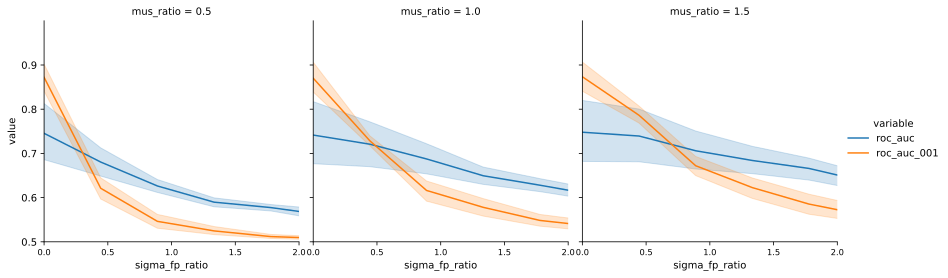

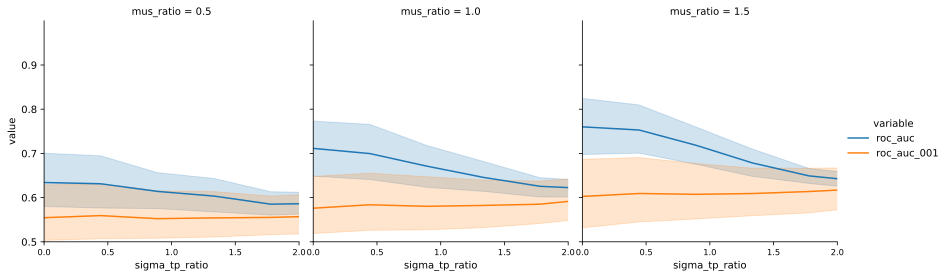

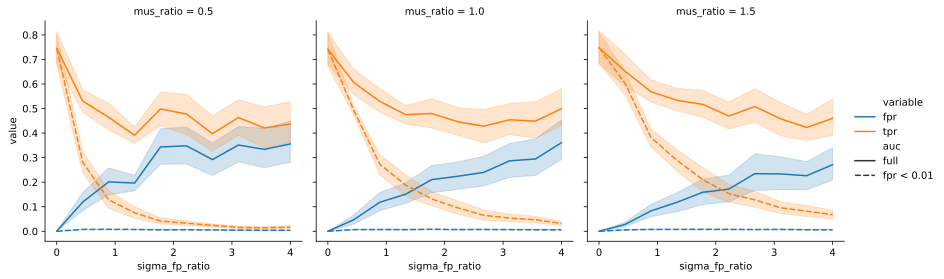

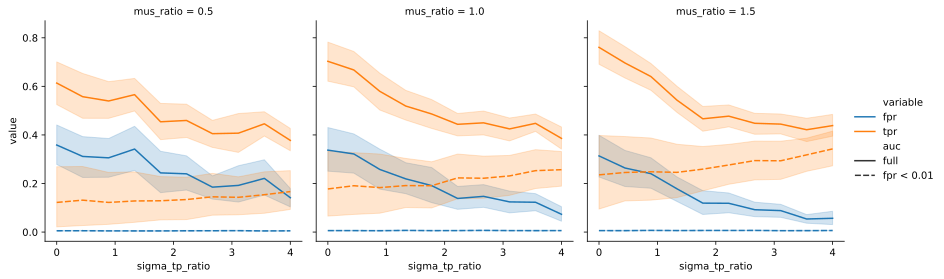

In [92]:

df = DF.melt(id_vars=['th', 'th_001_range', 'th_001', 'fpr_001', 'tpr_001', 'mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio', 'roc_auc', 'roc_auc_001'], value_vars=['fpr','tpr'])#.head(50)

_col='mus_ratio'

xmax = 2.0
xstep = 0.5
xticks = list(map(lambda x: xstep * x, range(int((xmax + 0.1)/xstep)))) + [xmax]

df = df[df['mus_ratio'] > 0.1]

df = DF.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['roc_auc', 'roc_auc_001'])
g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col,
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]

g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col,
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]



df = DF.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['fpr', 'fpr_001', 'tpr', 'tpr_001'])




df['auc'] = (df['variable'].str.find('_001') >= 0).apply(lambda x: 'fpr < 0.01' if x else 'full')
df['variable'] = df['variable'].str[0:3]



g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)



g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)

In [ ]:
from rule import db, get_df


get_df(db)

[None, None, None]

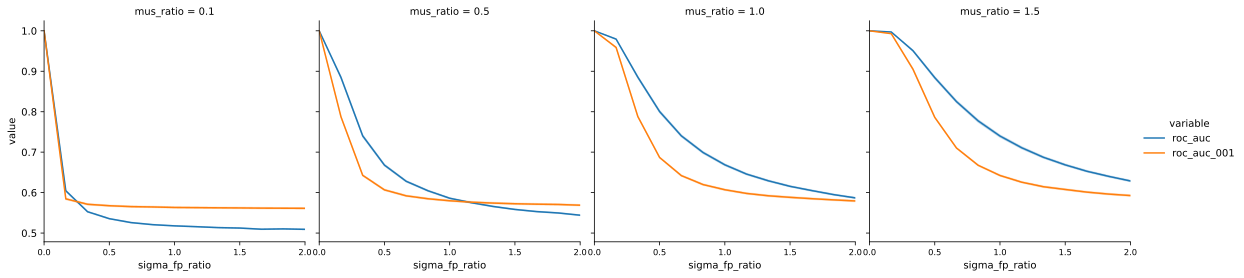

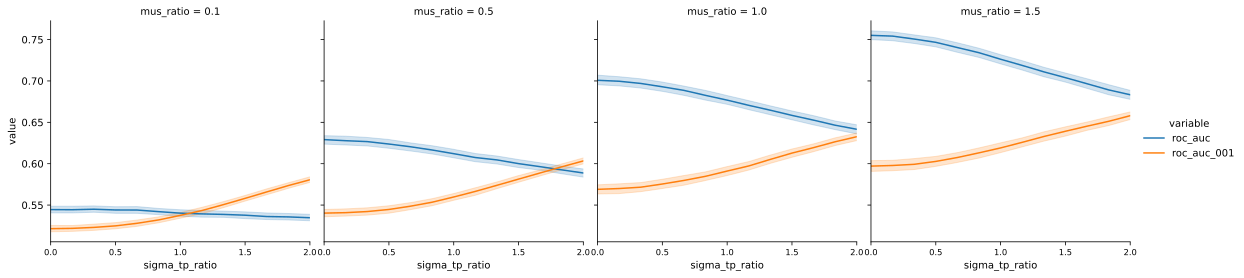

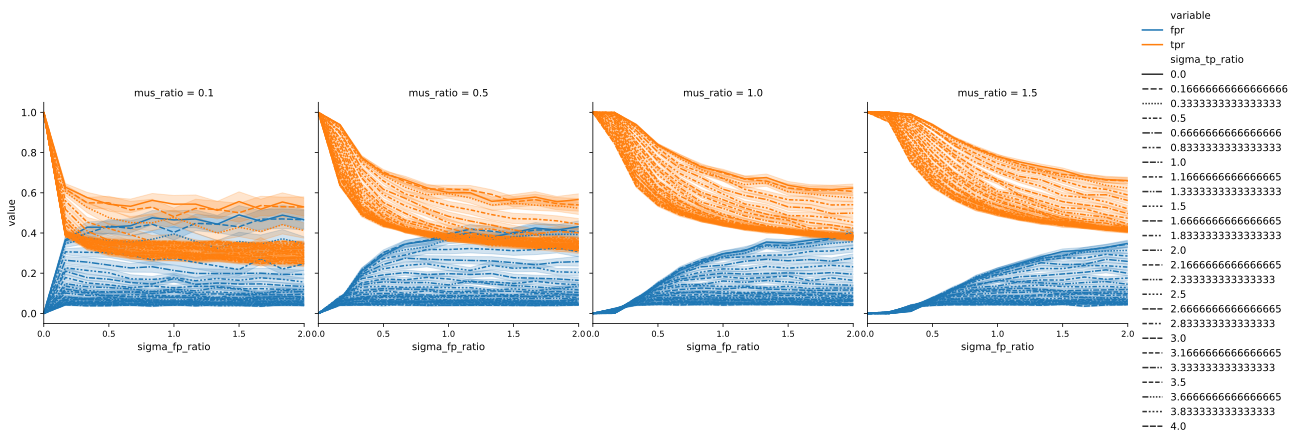

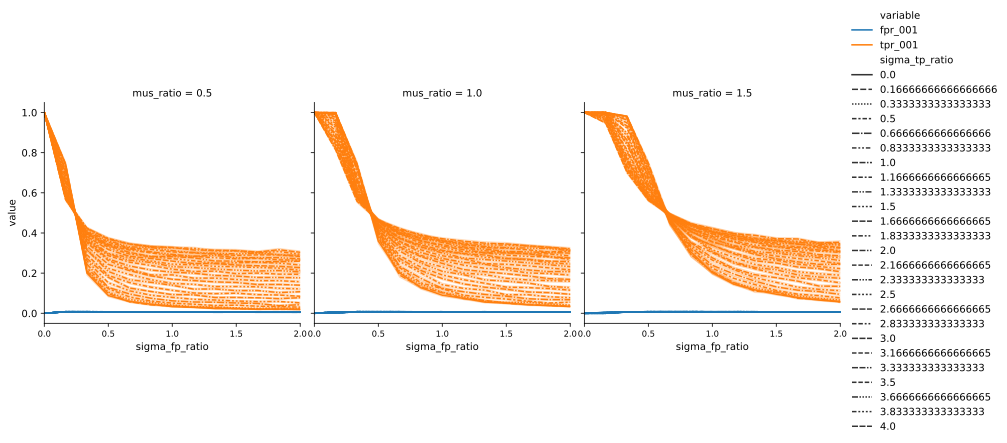

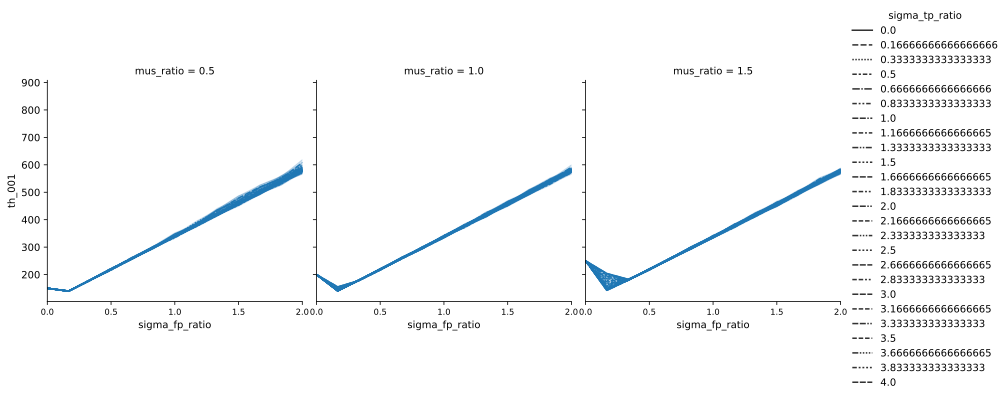

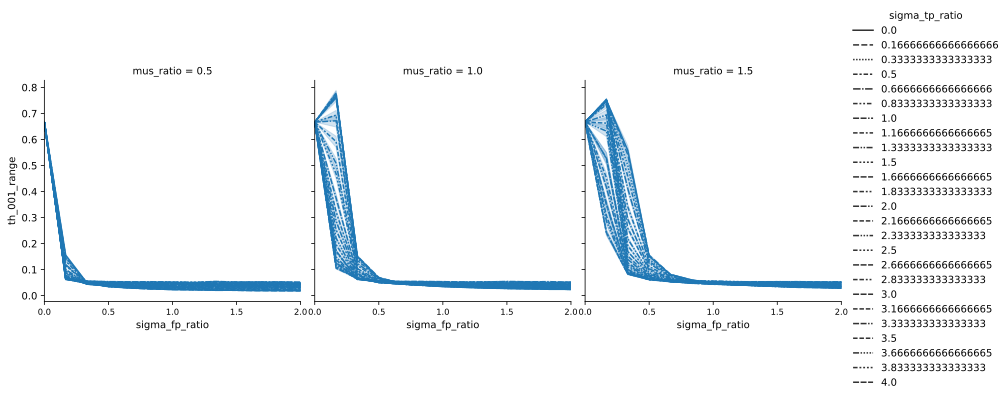

In [65]:



df = DF.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['fpr', 'tpr'])
g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col, style='sigma_tp_ratio',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)#np.concatenate((np.array([.1]), np.linspace(1.0, xmax, 8)), axis=0))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]



df = DF.melt(id_vars=[ 'th_001_range', 'th_001', 'mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio', 'roc_auc'], value_vars=['fpr_001','tpr_001'])#.head(50)
df = df[df['mus_ratio'] > 0.1]
df = df[df['sigma_fp_ratio'] <= (xmax + 1)]

g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col, style='sigma_tp_ratio',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)#np.concatenate((np.array([.1]), np.linspace(1.0, xmax, 8)), axis=0))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]

g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="th_001", col=_col, style='sigma_tp_ratio',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)#np.concatenate((np.array([.1]), np.linspace(1.0, xmax, 8)), axis=0))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]

g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="th_001_range", col=_col, style='sigma_tp_ratio',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)#np.concatenate((np.array([.1]), np.linspace(1.0, xmax, 8)), axis=0))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]
# g = sns.relplot(
#     data=df, kind="line",
#     x="sigma_fp_ratio", y="fpr_001", hue="mus_ratio", col='sigma_tp_ratio',
#     facet_kws=dict(sharex=False),
#     aspect=1.2,
#     height=3
# )


[None, None, None, None]

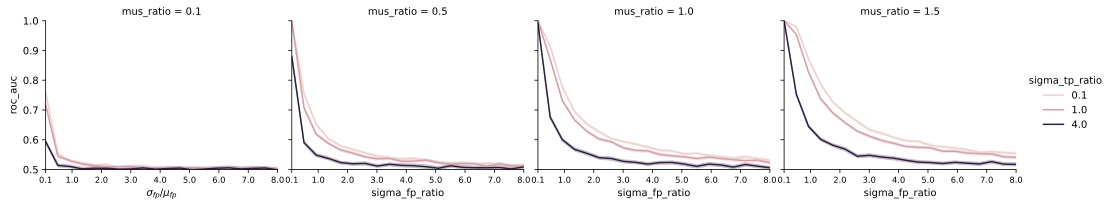

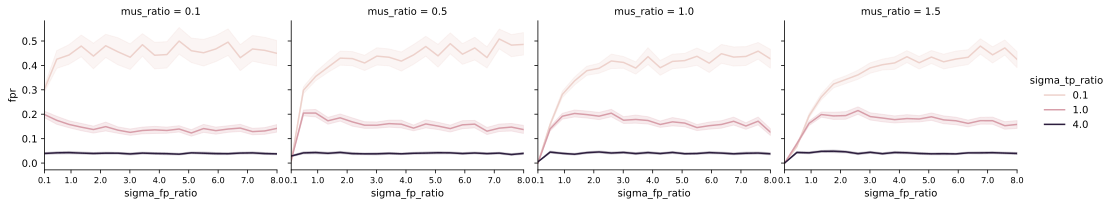

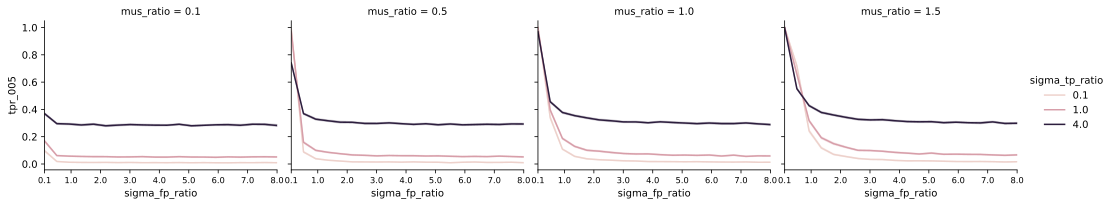

In [163]:

# df = pd.DataFrame(data, columns=['$\\mu_{tp}/\\mu_{fp}$', '$\\sigma_{fp}/\\mu_{fp}$', 'roc_auc'])
df = DF.copy()

_hue = 'sigma_tp_ratio'
_col='mus_ratio'
g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="roc_auc", hue=_hue, col=_col,
    facet_kws=dict(sharex=False),
    aspect=1.2,
    height=3
)
g.set(xlim=(0.1, 8.0), xticks=np.concatenate((np.array([.1]), np.linspace(1.0, 8.0, 8)), axis=0))
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: x/10 + 0.5, range(6))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]
g.axes[0,0].set_xlabel(r'$\sigma_{fp}/\mu_{fp}$')


# g = sns.relplot(
#     data=df, kind="line",
#     x="sigma_fp_ratio", y="tpr", hue=_hue, col=_col,
#     facet_kws=dict(sharex=False),
#     aspect=1.2,
#     height=3
# )



g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="fpr", hue=_hue, col=_col,
    facet_kws=dict(sharex=False),
    aspect=1.2,
    height=3
)
g.set(xlim=(0.1, 8.0), xticks=np.concatenate((np.array([.1]), np.linspace(1.0, 8.0, 8)), axis=0))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]

g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="tpr_001", hue=_hue, col=_col,
    facet_kws=dict(sharex=False),
    aspect=1.2,
    height=3
)
g.set(xlim=(0.1, 8.0), xticks=np.concatenate((np.array([.1]), np.linspace(1.0, 8.0, 8)), axis=0))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]


# g = sns.relplot(
#     data=df, kind="line",
#     x="sigma_fp_ratio", y="fpr_001", hue="mus_ratio", col='sigma_tp_ratio',
#     facet_kws=dict(sharex=False),
#     aspect=1.2,
#     height=3
# )


In [15]:


# Obiettivo: trovare i parametri ottimali per ottenere P(FP) = 0.35
def get_th(mu_fp, sigma_fp, FP_min, th_init):
    target_FP = FP_min

    # Funzione obiettivo per ottimizzare più parametri
    def objective(params, target_FP):
        th = params
        
        # Calcola P(FP)
        P_FP = 1 - norm.cdf(th, loc=mu_fp, scale=sigma_fp)
        
        # L'obiettivo è minimizzare la differenza assoluta tra P(FP) e il target desiderato
        return abs(P_FP - target_FP)

    # Inizializzazione con valori iniziali per i parametri
    initial_params = [th_init]  # mu_fp, sigma_fp, th

    # Minimizzazione per trovare i migliori valori di mu_fp, sigma_fp e th
    result = minimize(objective, x0=initial_params, args=(target_FP,), method='Nelder-Mead')

    # Output dei risultati
    optimal_th, = result.x
    optimal_FP = 1 - norm.cdf(optimal_th, loc=mu_fp, scale=sigma_fp)

    # print(f"Fixed mu_fp: {mu_fp:.4f}")
    # print(f"Fixed sigma_fp: {sigma_fp:.4f}")
    # print(f"Optimal th: {optimal_th:.4f}")
    # print(f"Resulting P(FP): {optimal_FP:.4f}\n")
    return optimal_th, optimal_FP


# Obiettivo: trovare i parametri ottimali per ottenere P(FP) = 0.35
def get_optimal_mu_tp(mu_fp, sigma_fp, th, sigma_tp, target_TP, mu_tp=100):

    # Funzione obiettivo per ottimizzare più parametri
    def objective(params, target_TP):
        mu_tp = params
        
        # Calcola P(FP)
        P_TP = 1 - norm.cdf(th - (mu_fp - sigma_fp), loc=mu_tp, scale=sigma_tp)
        
        # L'obiettivo è minimizzare la differenza assoluta tra P(FP) e il target desiderato
        return abs(P_TP - target_TP)

    # Inizializzazione con valori iniziali per i parametri
    initial_params = [mu_tp]  # mu_tp, sigma_tp

    # Minimizzazione per trovare i migliori valori di mu_fp, sigma_fp e th
    result = minimize(objective, x0=initial_params, args=(target_TP,), method='Nelder-Mead')

    # Output dei risultati
    optimal_mu_tp, = result.x
    optimal_TP = 1 - norm.cdf(th - (mu_fp - sigma_fp), loc=optimal_mu_tp, scale=sigma_tp)

    # print(f"Fixed mu_fp: {mu_fp:.4f}")
    # print(f"Fixed sigma_fp: {sigma_fp:.4f}")
    # print(f"Optimal th: {th:.4f}")
    # print(f"Fixed sigma_tp: {sigma_tp:.4f}")
    # print(f"Optimal mu_tp: {optimal_mu_tp:.4f}")
    # print(f"Optimal mu_tp/mu_fp: {optimal_mu_tp/mu_fp:.4f}")
    # print(f"Resulting P(TP): {optimal_TP:.4f}\n\n")
    return optimal_mu_tp/mu_fp, optimal_TP


def elaborate(mu_fps, sigma_fp_ratios, FP, TP):
    rs = []
    for mu_fp in mu_fps:
        for sigma_fp_ratio in sigma_fp_ratios:
            sigma_fp = mu_fp * sigma_fp_ratio
            th, optimal_FP = get_th(mu_fp, sigma_fp, FP, mu_fp)
            for mu_tp_ratio in [0.1, 0.4, 0.8, 1.0, 1.2]:
                r, optimal_TP = get_optimal_mu_tp(mu_fp, sigma_fp, th, 10, TP, mu_tp=mu_fp * mu_tp_ratio)
                rs.append([
                    mu_fp,
                    mu_tp_ratio * mu_fp,
                    optimal_FP,
                    optimal_TP,
                    sigma_fp_ratio,
                    th/mu_fp,
                    r
                ])
                pass

    return pd.DataFrame(rs, columns=['mu_fp', 'mu_tp', 'optimal_FP', 'optimal_TP', 'sigma_fp_prop', 'th/mu_fp', 'mu_tp/mu_fp']).round(2).set_index(['mu_fp', 'mu_tp', 'optimal_FP', 'optimal_TP', 'sigma_fp_prop', 'th/mu_fp', 'mu_tp/mu_fp'])

display(Markdown('''
In pratica, simulando FP e TP con una distribuzione normale, si envice che: per certi valori di mu_fp e mu_tp, se l'obbiettivo è
avere un certo FPR e un certo TPR, sigma_fp gioca un ruolo determinante.
'''))

_ = elaborate(mu_fps=[100],
          sigma_fp_ratios=map(lambda x: x*1.0/10.0, range(1, 11, 1)),
          FP=0.01, TP=0.8).sort_index()




In pratica, simulando FP e TP con una distribuzione normale, si envice che: per certi valori di mu_fp e mu_tp, se l'obbiettivo è
avere un certo FPR e un certo TPR, sigma_fp gioca un ruolo determinante.


In [28]:
from db import get_df, Database

db = Database()

pcaps = [('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]

for mu_fp in [5, 50, 100]:
    masked = True
    rs = []
    for mwname, pcap_id in pcaps:
        df = get_df(db, mwname, pcap_id, True, 'nx')
        mu_tp = df[df > 0 if masked else df >= 0]['p'].iloc[:30*24].mean()
        sigma_tp = df[df > 0 if masked else df >= 0]['p'].iloc[:30*24].std()

        _r = pow(mu_tp,2)/(pow(sigma_tp,2) - mu_tp)
        _p = mu_tp/pow(sigma_tp,2)

        for sigma_fp_ratio in map(lambda x: x*1.0/10.0, range(1, 11, 2)):
            sigma_fp = mu_fp * sigma_fp_ratio
            th, optimal_FP = get_th(mu_fp, sigma_fp, 0.01, mu_fp*0.9)

            calculated_TP = 1 - norm.cdf(th - (mu_fp - sigma_fp), loc=mu_tp, scale=sigma_tp)

            fps = np.random.normal(mu_fp, sigma_fp, size=30*24)
            tps = df['p'].to_numpy()

            n = tps == 0
            p = tps > 0
            tp = p & ((fps + tps) > th)
            fp = n & ((fps) > th)

            simulated_FP = fp.sum() / n.sum()
            simulated_TP = tp.sum() / p.sum()

            rs.append([
                mu_fp,
                sigma_fp,
                th,
                optimal_FP,
                mwname,
                mu_tp,
                sigma_tp,
                _r,
                _p,
                simulated_FP,
                simulated_TP,
                calculated_TP
            ])
            pass
        pass

    df = pd.DataFrame(rs, columns='mu_fp,sigma_fp,th,optimal_FP,mwname,mu_tp,sigma_tp,r,p,simulated_FP,simulated_TP,calculated_TP'.split(',')).round(2)
    df['delta_TP'] = df['calculated_TP'] - df['simulated_TP']
    df['delta_TP%'] = ((df['calculated_TP'] - df['simulated_TP'])*100).round(0).astype(int)
    display(df)#.sort_values(by='delta_TP'))
    display(df['delta_TP%'].describe())#.sort_values(by='delta_TP'))
    pass

,mu_fp,sigma_fp,th,optimal_FP,mwname,mu_tp,sigma_tp,r,p,simulated_FP,simulated_TP,calculated_TP,delta_TP,delta_TP%
0,5,0.5,6.16,0.01,caphaw,4.73,3.39,3.31,0.41,0.00,0.95,0.82,-0.13,-13
1,5,1.5,8.49,0.01,caphaw,4.73,3.39,3.31,0.41,0.02,0.58,0.47,-0.11,-11
2,5,2.5,10.82,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.35,0.14,-0.21,-21
3,5,3.5,13.14,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.21,0.02,-0.19,-19
4,5,4.5,15.47,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.14,0.00,-0.14,-14
5,5,0.5,6.16,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.52,0.50,-0.02,-2
6,5,1.5,8.49,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.11,0.15,0.04,4
7,5,2.5,10.82,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.06,0.02,-0.04,-4
8,5,3.5,13.14,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.03,0.00,-0.03,-3
9,5,4.5,15.47,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.03,0.00,-0.03,-3


count    20.000000
mean     -4.650000
std      13.452744
min     -27.000000
25%     -15.000000
50%      -3.500000
75%       2.500000
max      19.000000
Name: delta_TP%, dtype: float64

,mu_fp,sigma_fp,th,optimal_FP,mwname,mu_tp,sigma_tp,r,p,simulated_FP,simulated_TP,calculated_TP,delta_TP,delta_TP%
0,50,5.0,61.63,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.13,0.00,-0.13,-13
1,50,15.0,84.90,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.02,0.00,-0.02,-2
2,50,25.0,108.16,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.02,0.00,-0.02,-2
3,50,35.0,131.42,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.01,0.00,-0.01,-1
4,50,45.0,154.69,0.01,caphaw,4.73,3.39,3.31,0.41,0.02,0.01,0.00,-0.01,-1
5,50,5.0,61.63,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.05,0.00,-0.05,-5
6,50,15.0,84.90,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.01,0.00,-0.01,-1
7,50,25.0,108.16,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.02,0.00,-0.02,-2
8,50,35.0,131.42,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.01,0.00,-0.01,-1
9,50,45.0,154.69,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.01,0.00,-0.01,-1


count    20.000000
mean      2.000000
std       8.233436
min     -13.000000
25%      -2.000000
50%      -1.000000
75%       9.500000
max      18.000000
Name: delta_TP%, dtype: float64

,mu_fp,sigma_fp,th,optimal_FP,mwname,mu_tp,sigma_tp,r,p,simulated_FP,simulated_TP,calculated_TP,delta_TP,delta_TP%
0,100,10.0,123.26,0.01,caphaw,4.73,3.39,3.31,0.41,0.02,0.04,0.00,-0.04,-4
1,100,30.0,169.79,0.01,caphaw,4.73,3.39,3.31,0.41,0.00,0.02,0.00,-0.02,-2
2,100,50.0,216.32,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.01,0.00,-0.01,-1
3,100,70.0,262.84,0.01,caphaw,4.73,3.39,3.31,0.41,0.02,0.01,0.00,-0.01,-1
4,100,90.0,309.37,0.01,caphaw,4.73,3.39,3.31,0.41,0.01,0.01,0.00,-0.01,-1
5,100,10.0,123.26,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.03,0.00,-0.03,-3
6,100,30.0,169.79,0.01,zbot,1.67,3.18,0.33,0.16,0.01,0.01,0.00,-0.01,-1
7,100,50.0,216.32,0.01,zbot,1.67,3.18,0.33,0.16,0.02,0.01,0.00,-0.01,-1
8,100,70.0,262.84,0.01,zbot,1.67,3.18,0.33,0.16,0.00,0.00,0.00,0.00,0
9,100,90.0,309.37,0.01,zbot,1.67,3.18,0.33,0.16,0.02,0.01,0.00,-0.01,-1


count    20.000000
mean      0.750000
std       7.670003
min     -10.000000
25%      -3.250000
50%      -1.000000
75%       0.500000
max      19.000000
Name: delta_TP%, dtype: float64

In [34]:
from typing import Optional
from db import get_df, Database
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_auc_score, roc_curve

slot_h = 0.5

def get_pcaps(slot_h=1.):
    db = Database()

    DF_FP = get_df(db, 'normal', None, True, 'nx', slot_h=slot_h).iloc[0:int(8/slot_h)]

    dfs = {
        'healthy': DF_FP,
        'caphaw': get_df(db, 'caphaw', 54, True, 'nx'),
        'zbot': get_df(db, 'zbot', 46, True, 'nx'),
        'simda': get_df(db, 'simda', 58, True, 'nx'),
        'unknown': get_df(db, 'unknown', 57, True, 'nx'),
    }
    return dfs

def simulate_pcaps(dfs, slot_h, window_slots, fp_simulate=False, fp: Optional[SigmaMu]=None, fp_copies=1):
    df_fp = pd.concat([dfs['healthy'].copy() for _ in range(fp_copies)], axis=0).reset_index(drop=True)

    if not fp_simulate:
        window_slots = df_fp.shape[0]

    res = []
    for mw in dfs:
        if mw == 'healthy':
            continue
        df_tp = dfs[mw]
        skipped_all = 0
        skipped_any = 0
        for w in range(0, int(24*30/slot_h)):
            tps = df_tp.iloc[w:w + window_slots]['pp'].reset_index(drop=True)
            if tps.shape[0] < window_slots:
                break
            if fp_simulate and fp:
                fps = np.random.normal(fp.mu, fp.sigma, tps.shape[0])
            else:
                fps = df_fp['pp']

            labels = tps > 0

            if labels.all() or labels.any() == False:
                skipped_all += labels.all()
                skipped_any += labels.any() == False
                continue


            fpr, tpr, thresholds = roc_curve(labels, (fps + tps))
            roc_auc = auc(fpr, tpr)
            optimal_idx = np.argmax((tpr - fpr))

            roc_auc_001 = roc_auc_score(labels, (fps + tps), max_fpr=0.01)
            optimal_idx_fpr001 = np.argmax((fpr < 0.01) * (tpr - fpr))

            th_001_range = (fpr < 0.01).sum() / len(fpr)

            res.append([
                mw,
                w,
                fps.mean() if not (fp_simulate and fp) else fp.mu,
                fps.std() if not (fp_simulate and fp) else fp.sigma,
                tps.mean(),
                tps.std(),
                th_001_range,
                thresholds[optimal_idx],
                fpr[optimal_idx],
                tpr[optimal_idx],
                roc_auc,
                thresholds[optimal_idx_fpr001],
                fpr[optimal_idx_fpr001],
                tpr[optimal_idx_fpr001],
                roc_auc_001
            ])
            pass
        pass

    DF = pd.DataFrame(res, columns=[
        'mw',
        'w',
        'mu_fp',
        'sigma_fp',
        'mu_tp',
        'sigma_tp',
        'th_001_range',
        'thresholds',
        'fpr',
        'tpr',
        'roc_auc',
        'thresholds_001',
        'fpr_001',
        'tpr_001',
        'roc_auc_001'
    ])

    DF['mus_ratio'] = DF['mu_tp'] / DF['mu_fp']
    DF['sigma_fp_ratio'] = DF['sigma_fp'] / DF['mu_fp']
    DF['sigma_tp_ratio'] = DF['sigma_tp'] / DF['mu_tp']

    return DF


In [24]:
from math import ceil


if True:
    dfs = get_pcaps(0.5)


df = simulate_pcaps(dfs, 0.5, 16)

df = (df[['mw','w','mus_ratio', 'sigma_fp', 'sigma_tp', 'sigma_tp_ratio','th_001_range','fpr_001','tpr_001','roc_auc_001']]).round(2)


# sns.relplot(df, x='sigma_tp_ratio', y='roc_auc_001', row='mus_ratio', kind='scatter', height=3, aspect=3)


df = df[df['mus_ratio'] < 10]
# df['sigma_tp_ratio'] = pd.cut(df['sigma_tp_ratio'], 10, include_lowest=True)
# df['mus_ratio'] = pd.cut(df['mus_ratio'], 20, include_lowest=True)
df['mus_ratio'] = pd.qcut(df['mus_ratio'], 20, duplicates='drop')

for mus_ratio in df['mus_ratio'].dtype.categories:
    print(mus_ratio)
    _df = df[df['mus_ratio'] == mus_ratio].copy()
    _df['sigma_tp_ratio'] = pd.qcut(_df['sigma_tp_ratio'], 10, duplicates='drop')
    dfg = _df[['sigma_tp_ratio', 'mus_ratio', 'roc_auc_001', 'tpr_001']].groupby(['mus_ratio','sigma_tp_ratio'], observed=False).agg(['count','mean','std'])
    display(dfg.dropna())
    pass


caphaw 324 196
zbot 0 0
simda 29 646
unknown 0 623
0    1.738876
Name: sigma_fp_ratio, dtype: float64
(0.089, 0.45]


roc_auc_001                      \
                                                count      mean       std   
mus_ratio     sigma_tp_ratio                                                
(0.089, 0.45] (1.5290000000000001, 1.582]          11  0.627273  0.046710   
              (1.582, 1.832]                        5  0.672000  0.190578   
              (1.832, 1.93]                         7  0.517143  0.045356   
              (1.93, 2.23]                          3  0.553333  0.092376   
              (2.23, 2.654]                         5  0.566000  0.090443   
              (2.654, 2.9]                         17  0.588824  0.152270   
              (2.9, 4.0]                            4  0.502500  0.005000   

                                          tpr_001                      
                                            count      mean       std  
mus_ratio     sigma_tp_ratio                                           
(0.089, 0.45] (1.5290000000000001, 1.582]      11  0.254545  0.093420  
              (1.582, 1.832]                    5  0.350000  0.379144  
              (1.832, 1.93]                     7  0.035714  0.094491  
              (1.93, 2.23]                      3  0.110000  0.190526  
              (2.23, 2.654]                     5  0.132000  0.180748  
              (2.654, 2.9]                     17  0.176471  0.303170  
              (2.9, 4.0]                        4  0.000000  0.000000

(0.45, 0.64]


roc_auc_001                     tpr_001            \
                                  count      mean       std   count      mean   
mus_ratio    sigma_tp_ratio                                                     
(0.45, 0.64] (1.169, 1.33]           29  0.609310  0.084470      29  0.221379   
             (1.33, 1.44]            39  0.602051  0.089153      39  0.209744   
             (1.44, 1.65]            19  0.600000  0.066667      19  0.200000   
             (1.65, 1.66]            11  0.609091  0.053936      11  0.218182   
             (1.66, 2.2]              9  0.581111  0.084918       9  0.161111   

                                       
                                  std  
mus_ratio    sigma_tp_ratio            
(0.45, 0.64] (1.169, 1.33]   0.167198  
             (1.33, 1.44]    0.177059  
             (1.44, 1.65]    0.133333  
             (1.65, 1.66]    0.107872  
             (1.66, 2.2]     0.169148

(0.64, 0.73]


roc_auc_001                      \
                                              count      mean       std   
mus_ratio    sigma_tp_ratio                                               
(0.64, 0.73] (1.0290000000000001, 1.26]          51  0.581765  0.070191   
             (1.26, 1.46]                        39  0.602308  0.082986   
             (1.46, 2.19]                         8  0.621250  0.078638   

                                        tpr_001                      
                                          count      mean       std  
mus_ratio    sigma_tp_ratio                                          
(0.64, 0.73] (1.0290000000000001, 1.26]      51  0.166275  0.141350  
             (1.26, 1.46]                    39  0.209744  0.164740  
             (1.46, 2.19]                     8  0.246250  0.156565

(0.73, 0.82]


roc_auc_001                     tpr_001            \
                                  count      mean       std   count      mean   
mus_ratio    sigma_tp_ratio                                                     
(0.73, 0.82] (0.909, 1.12]           42  0.601667  0.083488      42  0.204286   
             (1.12, 1.29]            32  0.603437  0.099470      32  0.209687   
             (1.29, 1.45]            15  0.605333  0.076799      15  0.214667   
             (1.45, 1.94]             6  0.603333  0.089592       6  0.205000   

                                       
                                  std  
mus_ratio    sigma_tp_ratio            
(0.73, 0.82] (0.909, 1.12]   0.162948  
             (1.12, 1.29]    0.199362  
             (1.29, 1.45]    0.152075  
             (1.45, 1.94]    0.175812

(0.82, 0.91]


roc_auc_001                     tpr_001            \
                                  count      mean       std   count      mean   
mus_ratio    sigma_tp_ratio                                                     
(0.82, 0.91] (0.989, 1.15]           63  0.602857  0.086424      63  0.206349   
             (1.15, 1.29]            25  0.602000  0.047958      25  0.207200   
             (1.29, 1.84]             4  0.660000  0.123018       4  0.315000   

                                       
                                  std  
mus_ratio    sigma_tp_ratio            
(0.82, 0.91] (0.989, 1.15]   0.169737  
             (1.15, 1.29]    0.098553  
             (1.29, 1.84]    0.245561

(0.91, 1.0]


roc_auc_001                     tpr_001            \
                                 count      mean       std   count      mean   
mus_ratio   sigma_tp_ratio                                                     
(0.91, 1.0] (0.879, 1.02]           52  0.608846  0.091065      52  0.217692   
            (1.02, 1.15]            17  0.589412  0.068234      17  0.180588   
            (1.15, 1.38]             7  0.645714  0.131131       7  0.292857   
            (1.38, 1.66]             7  0.587143  0.047509       7  0.175714   

                                      
                                 std  
mus_ratio   sigma_tp_ratio            
(0.91, 1.0] (0.879, 1.02]   0.178332  
            (1.02, 1.15]    0.133813  
            (1.15, 1.38]    0.262406  
            (1.38, 1.66]    0.098634

(1.0, 1.09]


roc_auc_001                     tpr_001            \
                                 count      mean       std   count      mean   
mus_ratio   sigma_tp_ratio                                                     
(1.0, 1.09] (0.769, 0.91]           31  0.647097  0.149893      31  0.293226   
            (0.91, 1.03]            14  0.584286  0.080643      14  0.173571   
            (1.03, 1.14]             9  0.598889  0.062738       9  0.196667   
            (1.14, 1.24]             7  0.580000  0.048648       7  0.158571   
            (1.24, 1.42]            12  0.608333  0.035119      12  0.217500   
            (1.42, 1.85]             3  0.733333  0.251661       3  0.466667   

                                      
                                 std  
mus_ratio   sigma_tp_ratio            
(1.0, 1.09] (0.769, 0.91]   0.299125  
            (0.91, 1.03]    0.156284  
            (1.03, 1.14]    0.119373  
            (1.14, 1.24]    0.095469  
            (1.24, 1.42]    0.070211  
            (1.42, 1.85]    0.503322

(1.09, 1.18]


roc_auc_001                     tpr_001            \
                                  count      mean       std   count      mean   
mus_ratio    sigma_tp_ratio                                                     
(1.09, 1.18] (0.809, 0.92]           20  0.702000  0.170189      20  0.401500   
             (0.92, 1.12]            18  0.634444  0.109018      18  0.268333   
             (1.12, 1.29]             4  0.675000  0.096782       4  0.342500   
             (1.29, 3.4]              4  0.755000  0.166833       4  0.512500   

                                       
                                  std  
mus_ratio    sigma_tp_ratio            
(1.09, 1.18] (0.809, 0.92]   0.339353  
             (0.92, 1.12]    0.214483  
             (1.12, 1.29]    0.185000  
             (1.29, 3.4]     0.330290

(1.18, 1.45]


roc_auc_001                     tpr_001            \
                                  count      mean       std   count      mean   
mus_ratio    sigma_tp_ratio                                                     
(1.18, 1.45] (0.519, 0.71]            8  0.711250  0.189242       8  0.417500   
             (0.71, 0.73]             5  0.598000  0.087293       5  0.200000   
             (0.73, 0.82]             8  0.647500  0.098670       8  0.297500   
             (0.82, 0.91]             5  0.570000  0.027386       5  0.144000   
             (0.91, 1.01]             6  0.735000  0.164165       6  0.466667   
             (1.01, 1.21]             5  0.620000  0.045277       5  0.238000   
             (1.21, 1.32]             6  0.635000  0.049295       6  0.271667   
             (1.32, 1.38]             6  0.640000  0.080994       6  0.281667   
             (1.38, 1.46]            11  0.770909  0.091373      11  0.546364   

                                       
                                  std  
mus_ratio    sigma_tp_ratio            
(1.18, 1.45] (0.519, 0.71]   0.379614  
             (0.71, 0.73]    0.173638  
             (0.73, 0.82]    0.195503  
             (0.82, 0.91]    0.049295  
             (0.91, 1.01]    0.326599  
             (1.01, 1.21]    0.093648  
             (1.21, 1.32]    0.097860  
             (1.32, 1.38]    0.157787  
             (1.38, 1.46]    0.178565

(1.45, 1.73]


roc_auc_001                     tpr_001          \
                                  count      mean       std   count    mean   
mus_ratio    sigma_tp_ratio                                                   
(1.45, 1.73] (0.419, 0.454]           3  1.000000  0.000000       3  1.0000   
             (0.454, 0.55]            6  0.713333  0.178064       6  0.4250   
             (0.565, 0.72]            3  0.730000  0.234307       3  0.4600   
             (0.72, 1.05]             2  0.645000  0.205061       2  0.2900   
             (1.05, 1.11]             4  0.592500  0.053151       4  0.1925   
             (1.156, 1.16]            6  0.803333  0.218235       6  0.6100   
             (1.175, 1.39]            3  0.633333  0.115902       3  0.2700   

                                       
                                  std  
mus_ratio    sigma_tp_ratio            
(1.45, 1.73] (0.419, 0.454]  0.000000  
             (0.454, 0.55]   0.352746  
             (0.565, 0.72]   0.469361  
             (0.72, 1.05]    0.410122  
             (1.05, 1.11]    0.105317  
             (1.156, 1.16]   0.432851  
             (1.175, 1.39]   0.235160

(1.73, 2.64]


roc_auc_001                     tpr_001            \
                                  count      mean       std   count      mean   
mus_ratio    sigma_tp_ratio                                                     
(1.73, 2.64] (0.359, 0.49]            9  0.888889  0.181207       9  0.777778   
             (0.49, 0.53]             2  0.565000  0.007071       2  0.135000   
             (0.53, 0.54]             8  0.912500  0.143701       8  0.825000   
             (0.54, 0.58]             2  1.000000  0.000000       2  1.000000   
             (0.58, 0.61]             5  0.902000  0.156908       5  0.804000   
             (0.61, 0.69]             5  0.908000  0.205718       5  0.816000   
             (0.69, 0.73]             6  0.720000  0.181439       6  0.446667   
             (0.73, 0.81]             4  0.702500  0.109049       4  0.407500   
             (0.81, 0.95]             6  0.715000  0.201668       6  0.433333   
             (0.95, 2.61]             4  0.790000  0.243036       4  0.580000   

                                       
                                  std  
mus_ratio    sigma_tp_ratio            
(1.73, 2.64] (0.359, 0.49]   0.364238  
             (0.49, 0.53]    0.007071  
             (0.53, 0.54]    0.287054  
             (0.54, 0.58]    0.000000  
             (0.58, 0.61]    0.310210  
             (0.61, 0.69]    0.411437  
             (0.69, 0.73]    0.361810  
             (0.73, 0.81]    0.208866  
             (0.81, 0.95]    0.400783  
             (0.95, 2.61]    0.486073

(2.64, 2.829]


roc_auc_001                     tpr_001  \
                                   count      mean       std   count   
mus_ratio     sigma_tp_ratio                                           
(2.64, 2.829] (0.329, 0.44]            7  0.985714  0.037796       7   
              (0.44, 0.51]             5  0.820000  0.204939       5   
              (0.514, 0.52]            6  0.838333  0.179935       6   
              (0.52, 0.55]             2  1.000000  0.000000       2   
              (0.55, 0.58]             8  0.933750  0.142321       8   
              (0.58, 0.64]             5  0.926000  0.165469       5   
              (0.64, 0.67]             3  1.000000  0.000000       3   
              (0.67, 2.52]             3  0.736667  0.141892       3   

                                                  
                                  mean       std  
mus_ratio     sigma_tp_ratio                      
(2.64, 2.829] (0.329, 0.44]   0.971429  0.075593  
              (0.44, 0.51]    0.640000  0.409878  
              (0.514, 0.52]   0.678333  0.358297  
              (0.52, 0.55]    1.000000  0.000000  
              (0.55, 0.58]    0.866250  0.285304  
              (0.58, 0.64]    0.854000  0.326466  
              (0.64, 0.67]    1.000000  0.000000  
              (0.67, 2.52]    0.480000  0.288271

(2.829, 3.91]


roc_auc_001                   tpr_001            \
                                   count    mean       std   count      mean   
mus_ratio     sigma_tp_ratio                                                   
(2.829, 3.91] (0.409, 0.448]           5  1.0000  0.000000       5  1.000000   
              (0.448, 0.476]           5  0.9120  0.160530       5  0.828000   
              (0.476, 0.514]           5  0.9260  0.165469       5  0.854000   
              (0.514, 0.55]            6  1.0000  0.000000       6  1.000000   
              (0.55, 0.58]             4  0.9175  0.165000       4  0.832500   
              (0.58, 0.626]            4  0.9175  0.165000       4  0.832500   
              (0.626, 0.856]           5  0.9320  0.093113       5  0.868000   
              (0.856, 0.884]           5  0.9000  0.136931       5  0.800000   
              (0.884, 0.94]            6  0.8550  0.125180       6  0.708333   
              (0.94, 2.7]              4  0.8900  0.128062       4  0.775000   

                                        
                                   std  
mus_ratio     sigma_tp_ratio            
(2.829, 3.91] (0.409, 0.448]  0.000000  
              (0.448, 0.476]  0.316970  
              (0.476, 0.514]  0.326466  
              (0.514, 0.55]   0.000000  
              (0.55, 0.58]    0.335000  
              (0.58, 0.626]   0.335000  
              (0.626, 0.856]  0.180748  
              (0.856, 0.884]  0.273861  
              (0.884, 0.94]   0.250313  
              (0.94, 2.7]     0.262996

(3.91, 9.73]


roc_auc_001                     tpr_001            \
                                  count      mean       std   count      mean   
mus_ratio    sigma_tp_ratio                                                     
(3.91, 9.73] (0.449, 0.502]           5  0.980000  0.030822       5  0.960000   
             (0.502, 0.53]            6  0.983333  0.040825       6  0.966667   
             (0.53, 0.54]             3  1.000000  0.000000       3  1.000000   
             (0.54, 0.8]              4  1.000000  0.000000       4  1.000000   
             (0.8, 1.71]              4  1.000000  0.000000       4  1.000000   
             (1.71, 2.3]              4  0.802500  0.135739       4  0.602500   
             (2.3, 3.96]             16  0.793125  0.103712      16  0.586250   

                                       
                                  std  
mus_ratio    sigma_tp_ratio            
(3.91, 9.73] (0.449, 0.502]  0.058737  
             (0.502, 0.53]   0.081650  
             (0.53, 0.54]    0.000000  
             (0.54, 0.8]     0.000000  
             (0.8, 1.71]     0.000000  
             (1.71, 2.3]     0.273298  
             (2.3, 3.96]     0.207425

In [39]:
from math import ceil


if True:
    pcaps = get_pcaps(0.5)

dfs = []
for mu_fp in [1, 5, 50]:
    for sigma_fp_ratio in np.linspace(0.1, 4, 5):
        fp = SigmaMu(mu_fp, sigma_fp_ratio * mu_fp)
        
        df = simulate_pcaps(pcaps, 0.5, 16, fp_simulate=True, fp=fp)

        df = (df[['mw','w','mus_ratio', 'sigma_fp', 'sigma_tp', 'sigma_fp_ratio', 'sigma_tp_ratio','th_001_range','fpr_001','tpr_001','roc_auc_001']]).round(2)

        dfs.append(df)
        pass
    pass

df = pd.concat(dfs, axis=0)

# sns.relplot(df, x='sigma_tp_ratio', y='roc_auc_001', row='mus_ratio', kind='scatter', height=3, aspect=3)


# df = df[df['mus_ratio'] < 10]
# df['sigma_tp_ratio'] = pd.cut(df['sigma_tp_ratio'], 10, include_lowest=True)
# df['mus_ratio'] = pd.cut(df['mus_ratio'], 20, include_lowest=True)

df['mus_ratio'] = pd.cut(df['mus_ratio'], 3, duplicates='drop')
df['sigma_tp_ratio'] = pd.qcut(df['sigma_tp_ratio'], 10, duplicates='drop')

for mus_ratio in df['mus_ratio'].dtype.categories:
    print(mus_ratio)
    _df = df[df['mus_ratio'] == mus_ratio].copy()
    dfg = _df[['sigma_fp_ratio','sigma_tp_ratio', 'mus_ratio', 'roc_auc_001', 'tpr_001']].groupby(['mus_ratio','sigma_fp_ratio','sigma_tp_ratio'], observed=False).agg(['count','mean','std'])
    display(dfg.dropna())
    pass


(-0.0659, 21.96]


roc_auc_001            \
                                                     count      mean   
mus_ratio        sigma_fp_ratio sigma_tp_ratio                         
(-0.0659, 21.96] 0.10           (0.329, 0.58]          303  0.933894   
                                (0.58, 0.88]           333  0.866937   
                                (0.88, 1.02]           336  0.822470   
                                (1.02, 1.12]           279  0.825878   
                                (1.12, 1.17]           282  0.819965   
                                (1.17, 1.29]           345  0.826145   
                                (1.29, 1.44]           261  0.823295   
                                (1.44, 1.57]           270  0.824593   
                                (1.57, 2.56]           292  0.818562   
                                (2.56, 4.0]            257  0.938794   
                 1.08           (0.329, 0.58]          303  0.831089   
                                (0.58, 0.88]           333  0.703063   
                                (0.88, 1.02]           336  0.648869   
                                (1.02, 1.12]           279  0.623799   
                                (1.12, 1.17]           282  0.621738   
                                (1.17, 1.29]           345  0.610609   
                                (1.29, 1.44]           261  0.619617   
                                (1.44, 1.57]           270  0.632148   
                                (1.57, 2.56]           292  0.616096   
                                (2.56, 4.0]            257  0.827860   
                 2.05           (0.329, 0.58]          303  0.792211   
                                (0.58, 0.88]           333  0.663063   
                                (0.88, 1.02]           336  0.613423   
                                (1.02, 1.12]           279  0.590681   
                                (1.12, 1.17]           282  0.585106   
                                (1.17, 1.29]           345  0.577681   
                                (1.29, 1.44]           261  0.587471   
                                (1.44, 1.57]           270  0.589185   
                                (1.57, 2.56]           292  0.591130   
                                (2.56, 4.0]            257  0.800117   
                 3.02           (0.329, 0.58]          303  0.793927   
                                (0.58, 0.88]           333  0.656456   
                                (0.88, 1.02]           336  0.592679   
                                (1.02, 1.12]           279  0.569427   
                                (1.12, 1.17]           282  0.567128   
                                (1.17, 1.29]           345  0.565913   
                                (1.29, 1.44]           261  0.575172   
                                (1.44, 1.57]           270  0.576778   
                                (1.57, 2.56]           292  0.573288   
                                (2.56, 4.0]            257  0.773268   
                 4.00           (0.329, 0.58]          303  0.771023   
                                (0.58, 0.88]           333  0.662102   
                                (0.88, 1.02]           336  0.581280   
                                (1.02, 1.12]           279  0.572652   
                                (1.12, 1.17]           282  0.573085   
                                (1.17, 1.29]           345  0.561246   
                                (1.29, 1.44]           261  0.572912   
                                (1.44, 1.57]           270  0.566111   
                                (1.57, 2.56]           292  0.576301   
                                (2.56, 4.0]            257  0.766848   

                                                         tpr_001            \
                                                     std   count      mean   
mus_ratio        sigma_fp_ratio sigma_tp_ratio                            

(21.96, 43.92]


roc_auc_001           tpr_001  \
                                                   count mean  std   count   
mus_ratio      sigma_fp_ratio sigma_tp_ratio                                 
(21.96, 43.92] 0.10           (2.56, 4.0]              5  1.0  0.0       5   
               1.08           (2.56, 4.0]              5  1.0  0.0       5   
               2.05           (2.56, 4.0]              5  1.0  0.0       5   
               3.02           (2.56, 4.0]              5  1.0  0.0       5   
               4.00           (2.56, 4.0]              5  1.0  0.0       5   

                                                        
                                             mean  std  
mus_ratio      sigma_fp_ratio sigma_tp_ratio            
(21.96, 43.92] 0.10           (2.56, 4.0]     1.0  0.0  
               1.08           (2.56, 4.0]     1.0  0.0  
               2.05           (2.56, 4.0]     1.0  0.0  
               3.02           (2.56, 4.0]     1.0  0.0  
               4.00           (2.56, 4.0]     1.0  0.0

(43.92, 65.88]


roc_auc_001                      \
                                                   count      mean       std   
mus_ratio      sigma_fp_ratio sigma_tp_ratio                                   
(43.92, 65.88] 0.10           (1.57, 2.56]             5  1.000000  0.000000   
                              (2.56, 4.0]             38  1.000000  0.000000   
               1.08           (1.57, 2.56]             5  0.984000  0.021909   
                              (2.56, 4.0]             38  1.000000  0.000000   
               2.05           (1.57, 2.56]             5  0.992000  0.017889   
                              (2.56, 4.0]             38  1.000000  0.000000   
               3.02           (1.57, 2.56]             5  0.990000  0.022361   
                              (2.56, 4.0]             38  0.998421  0.009733   
               4.00           (1.57, 2.56]             5  0.954000  0.057271   
                              (2.56, 4.0]             38  0.997105  0.012500   

                                             tpr_001                      
                                               count      mean       std  
mus_ratio      sigma_fp_ratio sigma_tp_ratio                              
(43.92, 65.88] 0.10           (1.57, 2.56]         5  1.000000  0.000000  
                              (2.56, 4.0]         38  1.000000  0.000000  
               1.08           (1.57, 2.56]         5  0.968000  0.043818  
                              (2.56, 4.0]         38  1.000000  0.000000  
               2.05           (1.57, 2.56]         5  0.984000  0.035777  
                              (2.56, 4.0]         38  1.000000  0.000000  
               3.02           (1.57, 2.56]         5  0.982000  0.040249  
                              (2.56, 4.0]         38  0.997105  0.017844  
               4.00           (1.57, 2.56]         5  0.908000  0.118617  
                              (2.56, 4.0]         38  0.994474  0.023789

In [ ]:

df = DF.melt(id_vars=['mw', 'th_001_range', 'fpr_001', 'tpr_001', 'sigma_fp_ratio', 'sigma_tp_ratio', 'roc_auc', 'roc_auc_001'], value_vars=['fpr','tpr'])#.head(50)

_col='mw'

xmax = 2.0
xstep = 0.5
xticks = list(map(lambda x: xstep * x, range(int((xmax + 0.1)/xstep)))) + [xmax]

df = DF.melt(id_vars=['mw', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['roc_auc', 'roc_auc_001'])
g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col,
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]

g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col,
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]



df = DF.melt(id_vars=['mw', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['fpr', 'fpr_001', 'tpr', 'tpr_001'])




df['auc'] = (df['variable'].str.find('_001') >= 0).apply(lambda x: 'fpr < 0.01' if x else 'full')
df['variable'] = df['variable'].str[0:3]



g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)



g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)


In [62]:
def neg_rp(mu, sigma):
    try:
        _r = pow(mu,2)/(pow(sigma,2) - mu)
        _p = mu/pow(sigma,2)
        # print(f'{_r > 0 and (_p >= 0 and _p <=1)}\tmu={mu}\tsimga={sigma}\t_r={_r}\t_p={_p}')
        return _r, _p
    except:
        return neg_rp(mu - 1, sigma)

res = []
for mu, sigma_ratio in itertools.product([5, 50, 100], map(lambda x: x/10 + 0.5, range(1,10))):
    sigma = mu*sigma_ratio
    _r, _p= neg_rp(mu, sigma)
    res.append([
        mu, sigma, sigma_ratio, _r, _p
    ])

df = pd.DataFrame(res, columns='mu,sigma,sigma_ratio,_r,_p'.split(','))
print(all(df['_r'] > 0), all(df['_p'].between(0,1, inclusive='both')))
display(df)

True True


,mu,sigma,sigma_ratio,_r,_p
0,5,3.0,0.6,6.250000,0.555556
1,5,3.5,0.7,3.448276,0.408163
2,5,4.0,0.8,2.272727,0.312500
3,5,4.5,0.9,1.639344,0.246914
4,5,5.0,1.0,1.250000,0.200000
5,5,5.5,1.1,0.990099,0.165289
6,5,6.0,1.2,0.806452,0.138889
7,5,6.5,1.3,0.671141,0.118343
8,5,7.0,1.4,0.568182,0.102041
9,50,30.0,0.6,2.941176,0.055556
